# Information

In [19]:
import os

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc

allow_growth = True

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

In [2]:
kernel_size=(3,3)
pool_size=(4,4)
first_filters=32
second_filters=64

# build the model
model = Sequential()

model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(pool_size = pool_size)) 

model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = pool_size))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
     
    
# compile the model
model.compile(SGD(lr=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

model

In [3]:
base_dir = r'C:\Users\20153761\Documents\TUe\4e jaar\3e kwartiel\BIA'
train_batch_size=32
val_batch_size=32

# dataset parameters
TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

RESCALING_FACTOR = 1./255
     
# instantiate data generators
datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(VALID_PATH,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary',
                                        shuffle=False)
     
print(train_gen, val_gen)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
<tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x000002270E5B7CA0> <tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x0000022703E5F070>


In [4]:
datagen

In [5]:
train_gen

In [6]:
for layer in model.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)


In [7]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

In [8]:
model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

In [9]:
model_json

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 96, 96, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 96, 96, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainable": true, "dtype": "float32", "pool_size": [4, 4], "padding": "valid", "strides": [4, 4], "da

In [10]:
# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

In [11]:
# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

In [12]:
train_steps

4500

In [13]:
train_gen.n

144000

In [14]:
train_gen.batch_size

32

In [15]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

C:\Users\20153761\Anaconda3\envs\8p361\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
4500/4500 [==============================] - 1166s 258ms/step - loss: 0.5480 - accuracy: 0.7076 - val_loss: 0.4196 - val_accuracy: 0.8131

Epoch 00001: val_loss improved from inf to 0.41964, saving model to my_first_cnn_model_weights.hdf5
Epoch 2/3
4500/4500 [==============================] - 1054s 234ms/step - loss: 0.4077 - accuracy: 0.8194 - val_loss: 0.3447 - val_accuracy: 0.8512

Epoch 00002: val_loss improved from 0.41964 to 0.34474, saving model to my_first_cnn_model_weights.hdf5
Epoch 3/3
4500/4500 [==============================] - 1129s 251ms/step - loss: 0.3512 - accuracy: 0.8473 - val_loss: 0.3407 - val_accuracy: 0.8510

Epoch 00003: val_loss improved from 0.34474 to 0.34071, saving model to my_first_cnn_model_weights.hdf5


## Exersize 1

In [16]:
y = val_gen.labels                       
pred = model.predict_generator(val_gen)  
fpr, tpr, thresholds = roc_curve(y, pred) 
auc(fpr, tpr)

C:\Users\20153761\Anaconda3\envs\8p361\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.9320372499999999

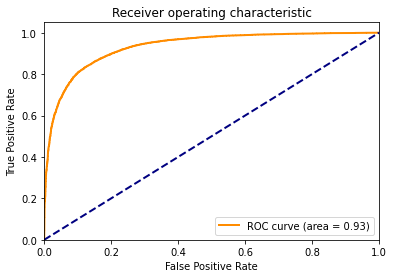

In [17]:
import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Exersize 2

In [22]:
def get_model_ex2(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))
     
     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(Conv2D(1, kernel_size, activation = 'sigmoid', padding = 'same'))
    
     model.add(MaxPool2D(pool_size = (6,6)))
     model.add(Reshape([1]))
    
     # compile the model
     model.compile(SGD(lr=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])
     
     return model

def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

# get model
model = get_model_ex2()
# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20153761\Documents\TUe\4e jaar\3e kwartiel\BIA')
    
for layer in model.layers:
    print(layer.output_shape)

# save the model and weights
model_name = 'Exercise_3_2'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 6, 6, 64)
(None, 6, 6, 1)
(None, 1, 1, 1)
(None, 1)


C:\Users\20153761\Anaconda3\envs\8p361\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
4500/4500 [==============================] - 983s 218ms/step - loss: 0.5445 - accuracy: 0.7122 - val_loss: 0.4337 - val_accuracy: 0.8015

Epoch 00001: val_loss improved from inf to 0.43370, saving model to Exercise_3_2_weights.hdf5
Epoch 2/3
4500/4500 [==============================] - 948s 211ms/step - loss: 0.4420 - accuracy: 0.7974 - val_loss: 0.4201 - val_accuracy: 0.8048

Epoch 00002: val_loss improved from 0.43370 to 0.42011, saving model to Exercise_3_2_weights.hdf5
Epoch 3/3
4500/4500 [==============================] - 930s 207ms/step - loss: 0.4129 - accuracy: 0.8127 - val_loss: 0.4079 - val_accuracy: 0.8196

Epoch 00003: val_loss improved from 0.42011 to 0.40790, saving model to Exercise_3_2_weights.hdf5


C:\Users\20153761\Anaconda3\envs\8p361\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


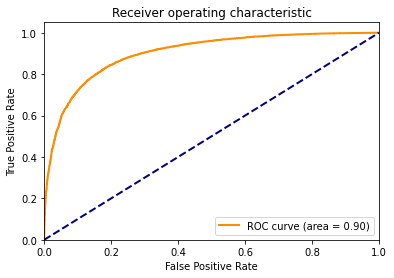

In [23]:
y = val_gen.labels                       
pred = model.predict_generator(val_gen)  
fpr, tpr, thresholds = roc_curve(y, pred)
auc(fpr, tpr)

roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Exersize 3

In [46]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

import glob
import pandas as pd
from matplotlib.pyplot import imread

from tensorflow.keras.models import model_from_json

#Change these variables to point at the locations and names of the test dataset and your models.
TEST_PATH = r"C:\Users\20153761\Documents\TUe\4e jaar\3e kwartiel\BIA\test\test"
MODEL_FILEPATH = 'Exercise_3_2.json' 
MODEL_WEIGHTS_FILEPATH = 'Exercise_3_2_weights.hdf5'

# load model and model weights
json_file = open(MODEL_FILEPATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# load weights into new model
model.load_weights(MODEL_WEIGHTS_FILEPATH)


# open the test set in batches (as it is a very big dataset) and make predictions
test_files = glob.glob(TEST_PATH + '\*.tif')

submission = pd.DataFrame()

file_batch = 5000
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):

    print('Indexes: %i - %i'%(idx, idx+file_batch))

    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})


    # get the image id 
    test_df['id'] = test_df.path.map(lambda x: x.split(os.sep)[-1].split('.')[0])
    test_df['image'] = test_df['path'].map(imread)
    
    
    K_test = np.stack(test_df['image'].values)
    
    # apply the same preprocessing as during draining
    K_test = K_test.astype('float')/255.0
    
    predictions = model.predict(K_test)
    
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])


# save your submission
submission.head()
submission.to_csv('submission.csv', index = False, header = True)


Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


In [42]:
test_files

[]

### http://localhost:6006/

##### 
````bash
activate 8p361
cd 'path/where/logs/are'
tensorboard --logdir logs
````